# WYS API - Investigate NULLs

This notebook investigates the rows with NULL speed and count columns.
(issue https://github.com/CityofToronto/bdit_data-sources/issues/393)   

**Summary**  
- there are currently `872` rows in `wys.raw_data`  
```
SELECT DISTINCT (api_id)
FROM wys.raw_data;
```


- `727` of these contain rows with NULL speed and count columns  
```
SELECT DISTINCT (api_id)
FROM wys.qc_raw_data_nulls;
```


- only `395` rows have matching geoms in `wys.wys_stat_signs_speed_limit`

In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import numpy as np 
import datetime
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib.dates as mdates
from matplotlib.lines import Line2D # for legend

In [2]:
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Config

In [4]:
# JUPYTERHUB
CONFIG=configparser.ConfigParser()
CONFIG.read('/home/cnangini/db.cfg')
dbset=CONFIG['DBSETTINGS']
con=connect(**dbset)
i=0

# Definitions

In [207]:
css = {
    'gray': '#787878', 'dark_gray': '#404040',
    'light_gray': '#A8A8A8'
}

# Plotting Functions

In [5]:
# for mulitliple line chart

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/cnangini/PROJECTS/bdit_data-sources/wys/api/lib/')

import linechart_fns

In [6]:
# Base settings for line chart
# sett_grp['data'].pop(2)
mode='Vehicles'
sett_base = {
    'lw': 3,'fontsize': 14,
    # Axes labels, limits, and grids
    'ylab': 'Daily Volume (' + mode + ')', 'xlab': 'Day',
    'major_loc': {'loc': mdates.DayLocator(),'fmt': mdates.DateFormatter('%d %b %Y')},
    'minor_loc': mdates.DayLocator(interval=1),  # every other day
    'major_grid_on': True,
    'major_grid': {
        'gridax': 'y', 'linewidth': 0.5, 'stroke':'#d3d3d3'
    },
    # legend
    'legend_label': True, 'legend_pos': 'lower left','legend_ncol': 4,
    'data': {
         0: {
            'lc': 'k', 'ls': 'solid',
            'leg': 'line 1'
            }
    },
    'shaded': {
        # Weekends
        0: {'lims':[[]], 'c': '#ccffff', 'alpha': 0.9 },
        # Lockdown2
        1: {'lims':[[pd.Timestamp('2020-06-22'), pd.Timestamp('2020-06-29')]],
            'c': '#CCBB44', #'zorder':-100,
            'alpha': 0.6,
            'label': {
                'x': pd.Timestamp('2020-06-22') + datetime.timedelta(days=1),
                'y': 39000, 'text': 'Lockdown 2',
                'fontsize': 12, 'colour': 'k', 'rotation': 0}},
        # Skeleton for installation area
        2: {'lims':[[]],
            'c': 'gray',
            'alpha': 0.7,
            'label': {
                'x': 999, # dummy placeholder value
                'y': 999, # dummy placeholder value
                'text': 'Installation',
                'fontsize': 12, 
                'colour': 'k', 
                'rotation': 0}},
    }
}

# Query Database

## Hourly number of NULL rows for each dt in each sign:
Currently 727 of 872 rows in `wys.raw_data` have NULL `count` and `speed` values.  

In [7]:
def get_nulls():
    '''Get signs and number of NULL rows in each hour of each dt.
    
    '''
    
    query="""
        SELECT api_id, dt, hour, num_null      
        FROM wys.qc_raw_data_nulls
    """

    with con:
        df = pandasql.read_sql(query, con)
        
    return df

In [9]:
# df=get_nulls()

# print(df.shape)
# df.head()

(161960, 4)


,api_id,dt,hour,num_null
0,1750,2021-03-30,0,6
1,1750,2021-03-30,1,7
2,1750,2021-03-30,2,10
3,1750,2021-03-30,3,9
4,1750,2021-03-30,4,9


In [12]:
saveflag=False
filename='df_nulls.csv'

if saveflag:
    fname=filename
    df.to_csv(fname, index=False)
else:
    df=pd.read_csv(filename)

## Geom of signs returned in `get_nulls()`
Note: Currently only `395` signs in `wys.qc_raw_data_nulls` have matching geoms in `wys.wys_stat_signs_speed_limit`.   

In [8]:
def get_null_geoms():
    '''Get coordinates of NULL signs.
    
    '''
    
    query="""
        SELECT api_id, lat, lon        
        FROM wys.qc_raw_data_nulls_geom
    """

    with con:
        df_geo = pandasql.read_sql(query, con)
        
    return df_geo

In [8]:
# df_geo=get_null_geoms()

# print(df_geo.shape) # (395, 3)
# df_geo.head()

(395, 3)


In [10]:
df_geo.head()

,api_id,lat,lon
0,1750,43.792496,-79.350678
1,1967,43.655830,-79.454555
2,2786,43.684964,-79.536916
3,2787,43.687118,-79.538962
4,2788,43.712468,-79.328337


# I Analysis

## I.1 NULLS per hour
Plot total number of NULL rows across all signs as a function of hour.  
Consider only hours where number of NULLs > `cutoff`, where here `cutoff = 5`.

In [31]:
cutoff = 5

In [263]:
# Sum of number of null rows per hour, for all rows where num_null > cutoff, over all api_ids

df_grp=df.loc[df['num_null']>cutoff, ['hour', 'num_null']].groupby(['hour']).sum()

Text(0, 0.5, 'Total number of null rows/hr')

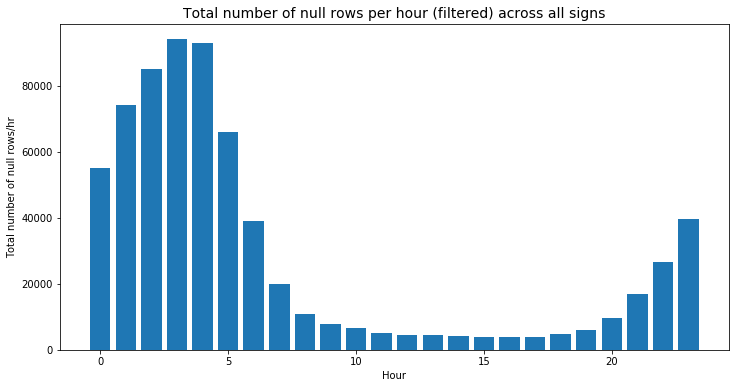

In [36]:
fig, ax =plt.subplots(1)
fig.set_size_inches(12, 6)
ax = plt.gca()

plt.bar(df_grp.index.values, df_grp['num_null'].values, width=0.8, bottom=None, align='center')
    
# fig.text(0.5, 0.07, 'Percent change COVID - BASELINE (%)', ha='center',size=fsize)
# fig.text(0.08, 0.5, 'Count', va='center', rotation='vertical', size=fsize)

ax.set_title('Total number of null rows per hour (filtered) across all signs', fontsize=14)
ax.set_xlabel('Hour')
ax.set_ylabel('Total number of null rows/hr')

**Fig 1: Total number of NULL rows summed by hour across all signs, considering only hours with more than `cutoff=5` NULL rows.**

## I.2 NULL dates
Find dates for each sign where for at least one hour per day there were more than `cutoff=5` NULL rows.  

=> `607` signs

In [48]:
df_daily=df.loc[df['num_null']>cutoff, ['api_id', 'dt', 'num_null']].groupby(['api_id','dt']).sum().reset_index()
print(list(df_daily))

['api_id', 'dt', 'num_null']


In [264]:
print(len(df_daily['api_id'].unique()))
df_daily.head()

607


,api_id,dt,num_null
0,1750,2021-03-30,48
1,1750,2021-03-31,55
2,1750,2021-04-01,36
3,1750,2021-04-02,40
4,1750,2021-04-03,52


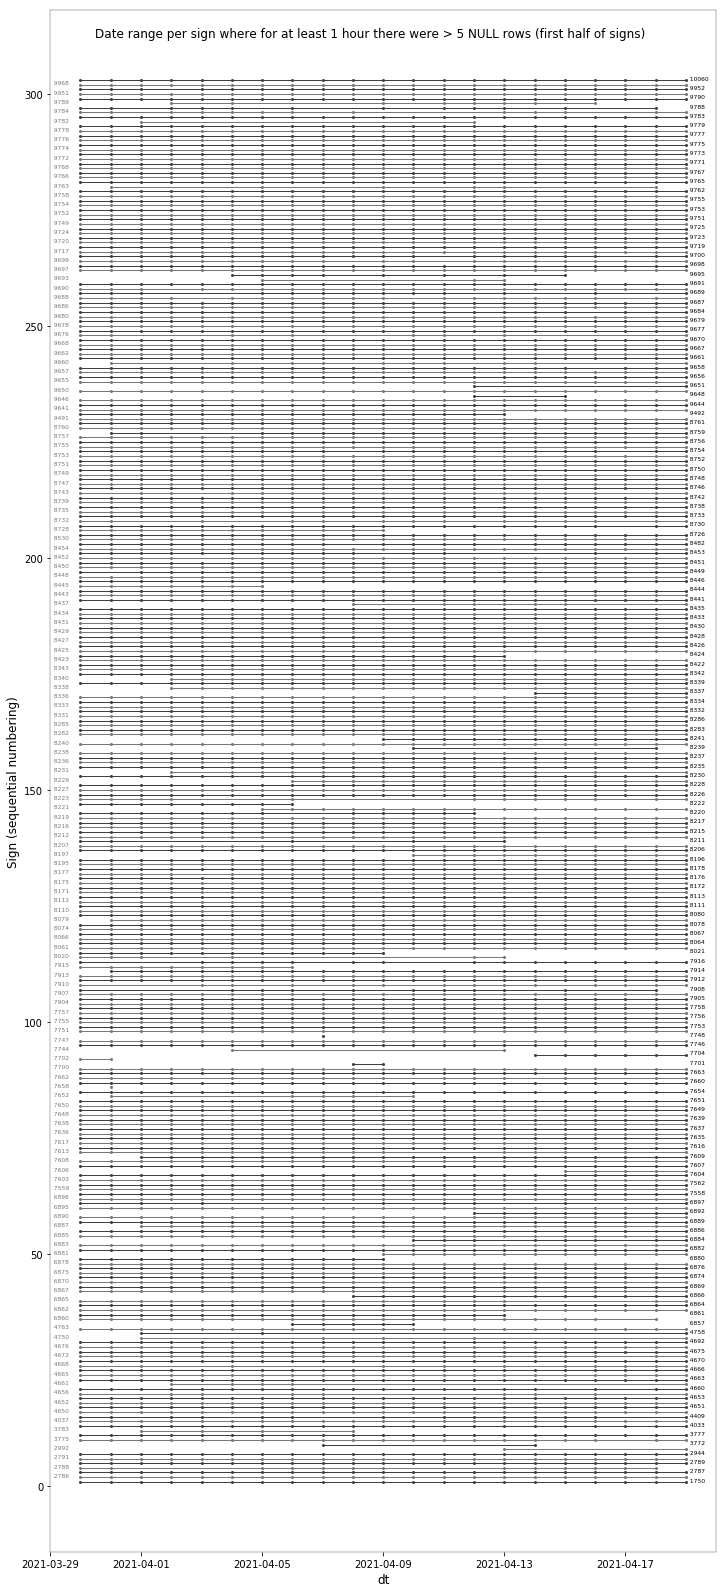

In [261]:
# Plot dates for each sign satifsying condition of at least one hour/day with > cutoff=5 NULL rows
# First half of all signs

fig, ax =plt.subplots(1)
fig.set_size_inches(10, 22)
ax = plt.gca()

num_api=len(df_daily['api_id'].unique())

# x-posn for annotation labels
x0_min=df_daily['dt'].min() - pd.DateOffset(1)
x0_max=df_daily['dt'].max()

idx=1
for this_id in df_daily['api_id'].unique()[:int(num_api/2)]:
    ypos=idx
    if ypos%2 == 0:
        line_colour=css['gray']
        x0=x0_min
        label_colour=line_colour
    else:
        line_colour=css['dark_gray']
        x0=x0_max
        label_colour='k'

    ax.plot(df_daily.loc[df_daily['api_id']==this_id, ['dt']], 
            df_daily.loc[df_daily['api_id']==this_id, ['api_id']].apply(lambda x: x*0+ypos), 
            linewidth=1, color=line_colour, marker='o', markersize=2)
    plt.text(x0, ypos,
             '  ' + str(this_id), color=label_colour, fontsize=6
                )
    idx+=1
    
fig.suptitle('Date range per sign where for at least 1 hour there were > 5 NULL rows (first half of signs)', fontsize=12)
fig.tight_layout()

ax.set_ylabel('Sign (sequential numbering)', fontsize=12)
ax.set_xlabel('dt', fontsize=12)

plt.show()

**Fig 2a: "Gantt" chart showing dates for signs where at least one hour in each day had more than `cutoff=5` NULL rows. Each line annotated by `api_id`. This plot shows the first `303` out of `607` signs.**

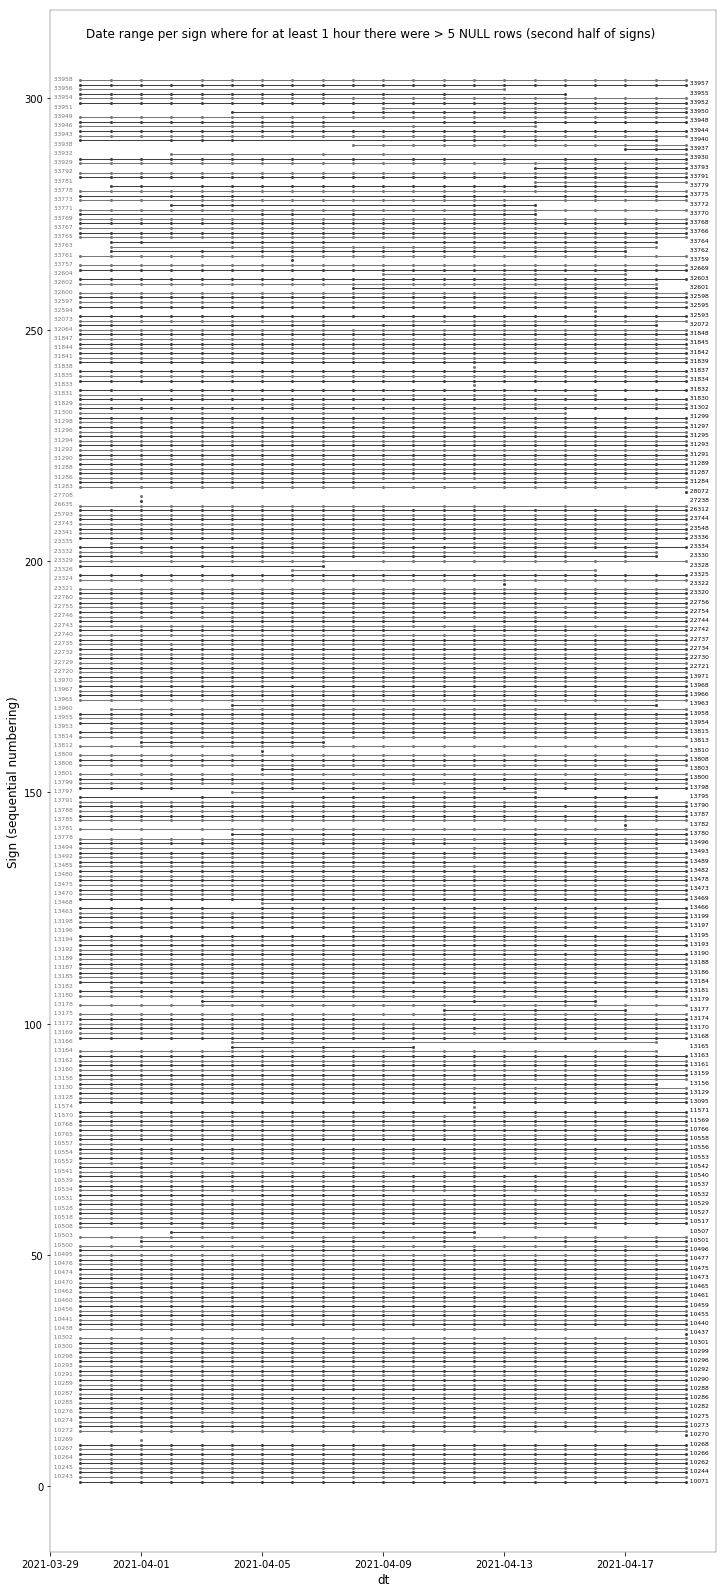

In [262]:
# Second half of all signs

fig, ax =plt.subplots(1)
fig.set_size_inches(10, 22)
ax = plt.gca()

num_api=len(df_daily['api_id'].unique())

# x-posn for annotation labels
x0_min=df_daily['dt'].min() - pd.DateOffset(1)
x0_max=df_daily['dt'].max()

idx=1
for this_id in df_daily['api_id'].unique()[int(num_api/2):]:
    ypos=idx
    if ypos%2 == 0:
        line_colour=css['gray']
        x0=x0_min
        label_colour=line_colour
    else:
        line_colour=css['dark_gray']
        x0=x0_max
        label_colour='k'

    ax.plot(df_daily.loc[df_daily['api_id']==this_id, ['dt']], 
            df_daily.loc[df_daily['api_id']==this_id, ['api_id']].apply(lambda x: x*0+ypos), 
            linewidth=1, color=line_colour, marker='o', markersize=2)
    plt.text(x0, ypos,
             '  ' + str(this_id), color=label_colour, fontsize=6
                )
    idx+=1
    
fig.suptitle('Date range per sign where for at least 1 hour there were > 5 NULL rows (second half of signs)', fontsize=12)
fig.tight_layout()

ax.set_ylabel('Sign (sequential numbering)', fontsize=12)
ax.set_xlabel('dt', fontsize=12)

plt.show()

**Fig 2b: "Gantt" chart showing dates for signs where at least one hour in each day had more than `cutoff=5` NULL rows. Each line annotated by `api_id`. This plot shows the last `304` out of `607` signs.**

<Figure size 432x288 with 0 Axes>

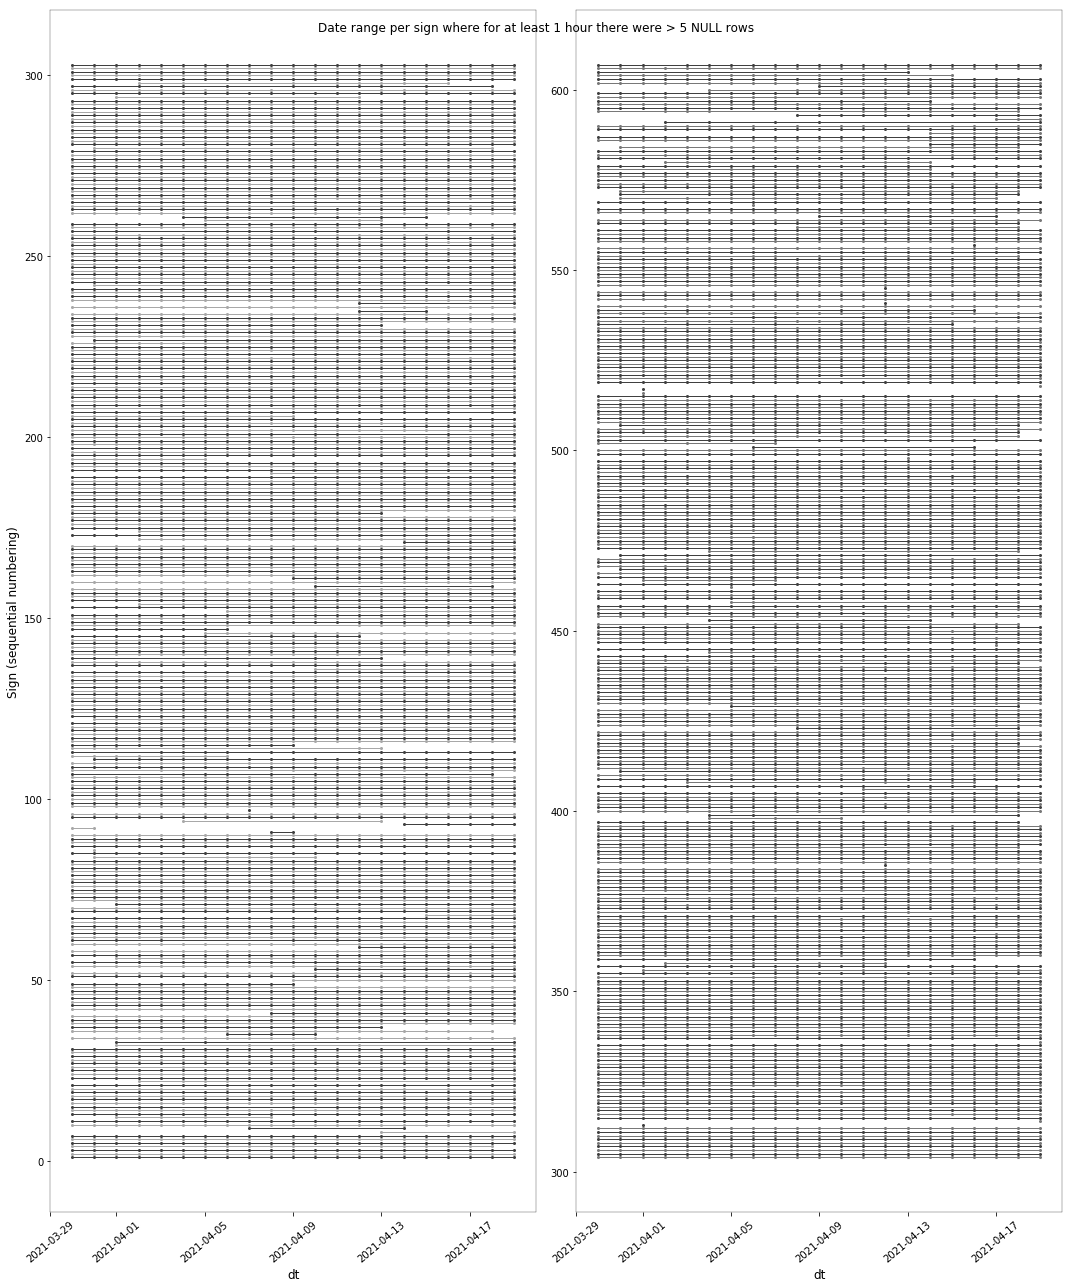

In [208]:
# First (left) and second (right) half of all signs

fig = plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,18))


num_api=len(df_daily['api_id'].unique())

idx=1
for this_id in df_daily['api_id'].unique()[:int(num_api/2)]:
    ypos=idx
    line_colour=css['light_gray'] if ypos%2 == 0 else css['dark_gray']    
    ax[0].plot(df_daily.loc[df_daily['api_id']==this_id, ['dt']], 
            df_daily.loc[df_daily['api_id']==this_id, ['api_id']].apply(lambda x: x*0+ypos), 
            linewidth=1, color=line_colour, marker='o', markersize=2)
    idx+=1


for this_id in df_daily['api_id'].unique()[int(num_api/2):]:
    ypos=idx
    line_colour=css['gray'] if ypos%2 == 0 else css['dark_gray']    
    ax[1].plot(df_daily.loc[df_daily['api_id']==this_id, ['dt']], 
            df_daily.loc[df_daily['api_id']==this_id, ['api_id']].apply(lambda x: x*0+ypos), 
            linewidth=1, color=line_colour, marker='o', markersize=2)
    idx+=1

fig.suptitle('Date range per sign where for at least 1 hour there were > 5 NULL rows', fontsize=12)
ax[0].tick_params(axis='x', labelrotation=40)
ax[1].tick_params(axis='x', labelrotation=40)


ax[0].set_ylabel('Sign (sequential numbering)', fontsize=12)
ax[0].set_xlabel('dt', fontsize=12)
ax[1].set_xlabel('dt', fontsize=12)

fig.tight_layout()
plt.show()

**Fig 2c: Condenses Fig 2a, b into two subplots.**